In [8]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pysm3
import pysm3.units as u
%matplotlib inline

Defining the ILC method. Which essentially does a linear combination of maps. Computes the inverse covariance of the combined maps and assigns frequency dependent weights. Finally compute the input maps with the ILC weights 

In [9]:
def ilc(maps, fgds, noise):
    #maps: input multi-frequency maps; np.array with dimensions (n_freqs, n_pixels)
    #fgds: input foreground maps; np.array with dimensions (n_freqs, n_pixels)
    #noise: input noise maps: np.array with dimensions (n_frews, n_pixels)

    #Computing the covariance of input maps
    cov= np.cov(maps) #numpy function to calculate covariance

    #Computing the inverse of the covariance
    inv_cov = np.linalg.inv(cov) #function to calculate the inv of a square matrix

    #CMB spectral energy density
    A= np.ones(maps.shape[0]) 
    #array filled with values of 1. size (shape) =5

    #Computing the weights
    w=(A @ inv_cov /(A @ (inv_cov @A)))
    w= np.sum(inv_cov, axis =1)/np.sum(inv_cov) #sums elements in an array. axis =1 sums along rows. None= sum of all elements
   

    #Linearly combining the maps with the corresponding weights to obtain the output ILC solution for the maps, foregrounds, and noise
    out = np.einsum ('j, ji->i', w, maps) 
    fgds_out = np.einsum ('j, ji->i', w, fgds)
    noise_out = np.einsum ('j, ji->i', w, noise)

    #Einstein Summation notation. vector of dim j multiplied by vector of dim i to get a vector of dim i

    return out, fgds_out, noise_out, w

Using PySM3 to simulate foreground and cmb maps. The noise is simulated as a random process and linked to the noise sensitivity of Planck

In [10]:
#simulating foregroud emission and noise at the different Planck frequencies

nside = 128

# Planck frequencies (in GHz)
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0,  545.0,  857.0])
n_freqs = len(freqs)

# Planck noise sensitivity (in uK_arcmin)
sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])

#Importing models for foregrounds and cmb using pysm sky module

sky_d = pysm3.Sky(nside=nside, preset_strings=["d1"])
sky_s = pysm3.Sky(nside=nside, preset_strings=["s1"])
sky_f = pysm3.Sky(nside=nside, preset_strings=["f1"])
sky_cmb = pysm3.Sky(nside=nside, preset_strings=["c1"])

# Initialization of lists to collect maps of different components at different frequencies
noise_pl = []
dust_pl = []
sync_pl = []
ff_pl = []
cmb_pl =[]
for nf in range(n_freqs):
    #noise
    noise= (np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True))
    noise_pl.append(noise)
    #foregrounds
    dust= sky_d.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    dust_pl.append(dust)
    sync=sky_s.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))

    sync_pl.append(sync)
    ff=sky_f.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    ff_pl.append(ff)
    #cmb
    cmb = sky_cmb.get_emission(freqs[nf] * u.GHz)[0]* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    cmb_pl.append(cmb)


# Making lists numpy arrays. Their dimension is (N_freq,N_pixels).
noise_pl=np.array(noise_pl)
dust_pl=np.array(dust_pl)
sync_pl=np.array(sync_pl)
ff_pl=np.array(ff_pl)
cmb_pl = np.array(cmb_pl)


Combining the CMB and foreground maps to be input into ILC

In [11]:
maps_pl = cmb_pl + noise_pl + dust_pl + sync_pl + ff_pl #cmb and foregrounds combined
fgds_pl= dust_pl + sync_pl + ff_pl #combined foregrounds

Running the ILC function

In [12]:
ilc_cmb, fgds, noise, w=ilc(maps_pl, fgds_pl, noise_pl)
diff=cmb_pl -ilc_cmb

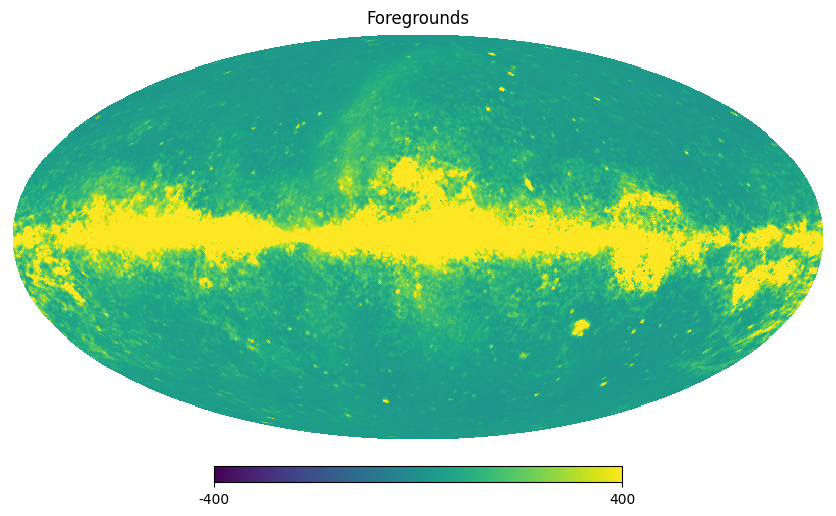

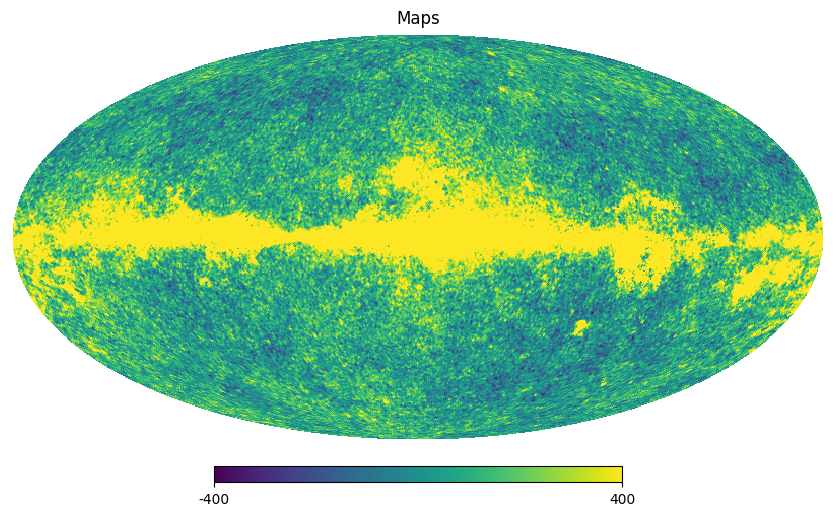

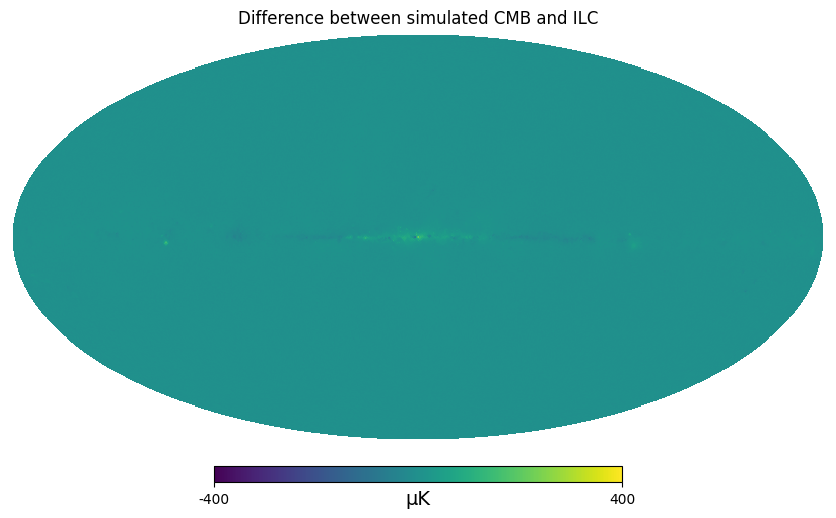

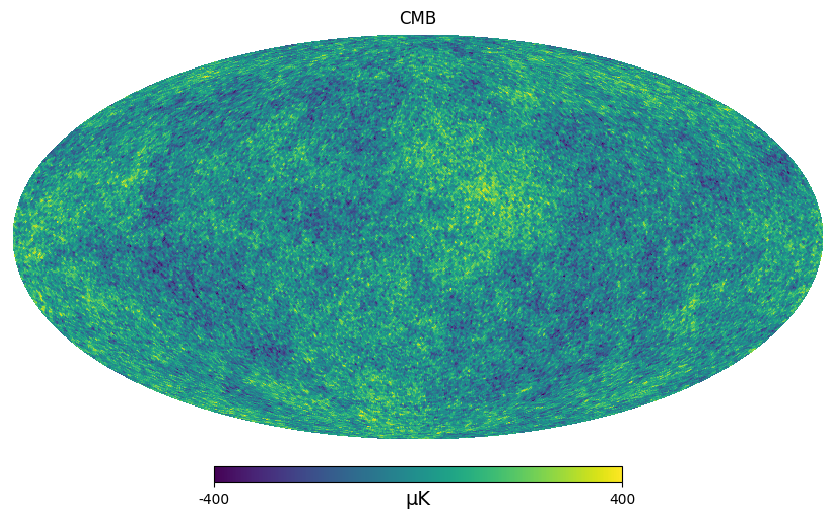

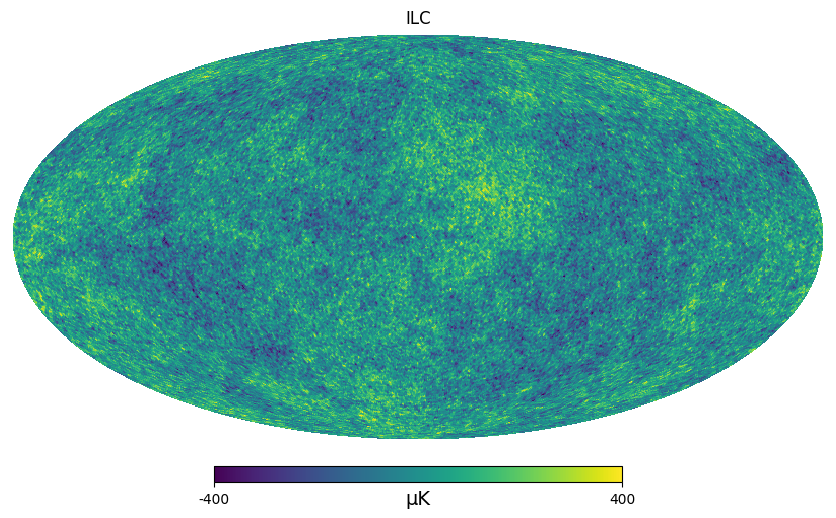

In [14]:

hp.mollview(fgds_pl[0], title ="Foregrounds", cmap="viridis", min=-400, max=400)
hp.mollview(maps_pl[0], title ="Maps", cmap="viridis", min=-400, max=400)
#hp.mollview(noise_pl[0], title ="Noise", cmap="viridis", min=-400, max=400)
hp.mollview(diff[0], title ="Difference between simulated CMB and ILC", cmap="viridis", min=-400, max=400, unit ="μK")
hp.mollview(cmb_pl[0], title ="CMB", cmap="viridis", min=-400, max=400, unit ="μK")
hp.mollview(ilc_cmb, title ="ILC", cmap="viridis", min=-400, max=400, unit ="μK")